In [1]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import scipy.io as io
import time as time_pkg
%matplotlib inline

## Sample entropy function

In [2]:
import numpy as np

def sampen_wiki(L, m, r):
    N = len(L)
    B = 0.0
    A = 0.0
    
    
    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])
    
    print(B, A)

    # Return SampEn
    return -np.log(A / B)

In [200]:
def coarse_scale(total_signal, gamma, downscale = False):
    #total signal is a N x 1 vector!
    
    if len(total_signal.shape) < 1:
        total_signal = total_signal.reshape(-1, 1)
    
    elif total_signal.shape[0] == 1: #row vector
        total_signal = total_signal.T
    
    if downscale:
        print("Please do not use downscale.")
        raise SystemExit
        
        #return total_signal[range(0, len(total_signal), gamma)]
    
    else:    

        N, p = total_signal.shape

        new_size = int(N / gamma)

        new_signal = np.zeros((new_size, p))

        for i in range(p):
            #extract ith signal
            signal = total_signal[: new_size * gamma, i] #Cut off ends if it is not even

            #resize
            signal = signal.reshape(new_size, gamma)

            new_signal[:, i] = np.mean(signal, axis = 1)
            
        return new_signal 


def SampEn(data, m, r, tau = 1, gamma = 1, normalise_flag = False, downscale_flag = False):
    #r is a percentage
    #tau controls the time delay
    #gamma specifies if you compute the coarse grained signal or not
    
    signal = deepcopy(data)
    
    #Normalise signal and calculate r_tol
    if normalise_flag:
        
        signal = (signal - np.mean(signal)) / np.std(signal)
        r_tol = r
    
    else:
        #Calculate r_tol
        r_tol = r * np.std(signal)
    
    if len(signal.shape) > 1:
        print("You have multivariate data!")
        multi_flag = True
        N, p = signal.shape
        
    else:
        multi_flag = False
        signal = signal.reshape(-1, 1) #Make as if it was multivariate
    
    if gamma > 1:
        signal = coarse_scale(signal, gamma, downscale_flag)

        print("New shape: {}".format(signal.shape))

    N = len(signal)
    B = 0.0
    A = 0.0
    
    #Create data matrix for m and m + 1 case
    #Bmat = np.zeros(( int((N - m) / tau), m))
    #Amat = np.zeros(( int((N - m) / tau), m + 1))
    
    #for i in range(0, m, 1):
    #    range1 = range(i, N - m + i, tau)
        
    #    Bmat[:, i] = signal[range1]
    #    Amat[:, i] = signal[range1]
    
    #Add on last column to Amat
    #Amat[:, -1] = signal[m:]
    
    #Compute B vectors
    start = 0
    end = start + (m - 1) * tau + 1
    
    B = []
    cnt = 0
    while end <= N:
        #print(start, end, cnt)
        B.append(np.array([signal[range(start, end, tau), i] for i in range(signal.shape[1]) ]).reshape(-1))
        
        start += 1
        end = start + (m - 1) * tau + 1
        cnt += 1
    
    Bmat = np.array(B)
    
    #Compute A vectors, m + 1 case
    start = 0
    end = start + (m) * tau + 1
    
    A = []
    cnt = 0
    
    while end <= N:
        A.append(np.array([signal[range(start, end, tau), i] for i in range(signal.shape[1]) ]).reshape(-1))
        
        start += 1
        end = start + (m) * tau + 1
        cnt += 1
    
    Amat = np.array(A)
    
    #print(Bmat, Bmat.shape)
    #print(Amat, Amat.shape)
    
    #Loop through rows
    B_count = np.zeros(Bmat.shape[0])
    A_count = np.zeros(Amat.shape[0])
    
    #B calculation
    for i in range(0, Bmat.shape[0], 1):
        abs_difference = np.abs(Bmat - Bmat[i, :])
        
        distance_B = np.max(abs_difference, axis = 1)
        #Adjust ith term to be larger than r_tol so that it is not included in the sum
        distance_B[i] = r_tol + 10
        
        #print(distance_B, np.sum(distance_B  <= r_tol))
        
        B_count[i] = ( np.sum(distance_B  <= r_tol) )# / (N - m * tau - 1)
    
    #A calculation
    for i in range(0, Amat.shape[0], 1):
        abs_difference = np.abs(Amat - Amat[i, :])
        distance_A = np.max(abs_difference, axis = 1)
        
        #Adjust ith term to be larger than r_tol so that it is not included in the sum
        distance_A[i] = r_tol + 10
        
        #print(distance_A, np.sum(distance_A  <= r_tol))
        
        A_count[i] = ( np.sum(distance_A  <= r_tol) )# / (N - m * tau - 1)
    
    B = np.sum(B_count)
    A = np.sum(A_count)

    return -np.log(A / B)


#SampEn(a, 2, 0.2, tau = 1, gamma = 1, normalise_flag = False, downscale_flag = False)

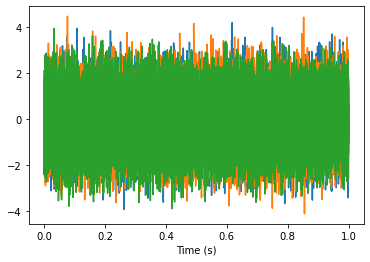

You have multivariate data!


C:\Users\RYANB~1.LAP\AppData\Local\Temp/ipykernel_13964/1975998633.py:150: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)


You have multivariate data!
New shape: (15000, 3)
You have multivariate data!
New shape: (10000, 3)
You have multivariate data!
New shape: (7500, 3)
You have multivariate data!
New shape: (6000, 3)
You have multivariate data!
New shape: (5000, 3)
You have multivariate data!
New shape: (4285, 3)
You have multivariate data!
New shape: (3750, 3)
You have multivariate data!
New shape: (3333, 3)
You have multivariate data!
New shape: (3000, 3)
You have multivariate data!
New shape: (2727, 3)
You have multivariate data!
New shape: (2500, 3)
You have multivariate data!
New shape: (2307, 3)
You have multivariate data!
New shape: (2142, 3)
You have multivariate data!
New shape: (2000, 3)
You have multivariate data!
New shape: (1875, 3)
You have multivariate data!
New shape: (1764, 3)
You have multivariate data!
New shape: (1666, 3)
You have multivariate data!
New shape: (1578, 3)
You have multivariate data!
New shape: (1500, 3)


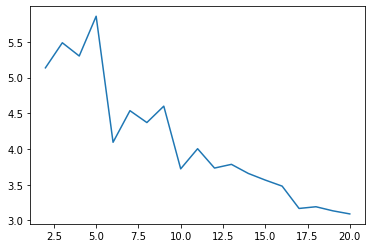

In [207]:
Fs = 30000
t =  np.arange(0, 1, 1 / Fs)
signal = np.random.randn(Fs) #np.sin(2 * np.pi * t)#

signal = np.vstack((np.random.randn(Fs), np.random.randn(Fs), np.random.randn(Fs))).T

plt.figure()
plt.plot(t, signal)
plt.xlabel("Time (s)")
plt.show()

gamma_range = range(1, 21, 1)
SEn_vals = []

for gamma_loop in gamma_range:
    SEn_vals.append(SampEn(signal, 2, 0.15, tau = 1, gamma = gamma_loop, normalise_flag = False, downscale_flag=False))

plt.figure()
plt.plot(gamma_range, SEn_vals)
plt.show()


## Variational Mode Decomposition

In [2]:
class variational_mode_decomposition(object):
    
    def __init__(self, alpha, K, tau, DC = False, init = 1, n_iter = 500, tol = 1e-6, memory_flag = True):
        
        self.alpha = alpha #balancing parameter
        self.K = K #Number of IMFs/number of modes to be recovered
        self.tau = tau #tau = time-step dual ascent
        self.DC = DC # DC = True if the first mode is a DC component
        self.init = init #Select how center frequencies are initialised, 
        self.n_iter = n_iter #maximum number of iterations to perform
        self.tol = tol #iteration tolerance on updates
        self.eps = 2.220446049250313e-016
        self.memory_flag = memory_flag #If True, only store 2 iterations and just reuse the matrices (only applied to u_hat_plus)
        
    def get_params(self):
        
        return {"K":self.K, "alpha":self.alpha}
    
    def set_params(self, dict_params):
        
        self.K = dict_params["K"]
        self.alpha = dict_params["alpha"]
        
    def VMD(self, signal):
        
        signal = signal.reshape(-1)

        Alpha = np.ones(self.K) * self.alpha 
        
        #original parameters
        save_T = len(signal)
        Fs = 1/save_T

        #Mirror signal
        T = save_T

        f_mirror = np.zeros(2 * T)
        f_mirror[:T//2] = signal[ : T // 2][::-1]
        f_mirror[T//2 : 3 * T //2 ] = signal
        f_mirror[3 * T //2 : ] = signal[T//2 :][::-1]

        f = f_mirror

        #Extend time domain
        T *= 2
        t = np.arange(1, T + 1, 1) / T

        #spectral discretisation
        freqs = t - 0.5 - 1/T

        #calculate spectral information
        f_hat = np.fft.fftshift((np.fft.fft(f)))
        f_hat_plus = f_hat

        #Turn off one half
        f_hat_plus[:T//2] = 0
        
        #Generate storage matrices
        omega_plus = np.zeros((self.n_iter, self.K))

        if self.init == 0:
            pass #all omegas are zero

        elif self.init == 1:
            omega_plus[0, :] = [(0.5 / self.K)*(i) for i in range(self.K)] #all omegas are uniformly distributed

        elif self.init == 2:
            omega_plus[0, :] = np.sort(np.exp(np.log(Fs) + (np.log(0.5 / Fs))) * np.random.random(size = self.K)) #all omegas are randomly selected in [0, 1]
        
        else:
            print("Invalid init ({}) entered.".format(self.init))
            raise SystemExit
        
        if self.DC:
            omega_plus[0, 0] = 0
        
        if self.memory_flag:
            #Store u_hat in frequency (complex) domain for all iterations
            u_hat_plus = np.zeros((3, len(freqs), self.K), dtype=np.complex_)  #3 because first iteration is out of the loop
            
        else:
            #Store u_hat in frequency (complex) domain for all iterations
            u_hat_plus = np.zeros((self.n_iter, len(freqs), self.K), dtype=np.complex_)  
        
        #Set up lambda variables
        lambda_hat = np.zeros((self.n_iter, len(freqs)), dtype=np.complex_)
        
        #initialise other stuff for loops
        uDiff = np.inf
        n = 0 #global counter
        n_memory = 0 #if memory_flag = False, n = n_global (only used for u_hat_plus, to store local u_hat_plus indices)
        sum_uk = 0
        uDiff_list = []

        while uDiff > self.tol and n <= self.n_iter - 2:
            
            k = 0
            
            #Calculate IMF sum excluding first term
            #Think about loop restart (all zero initially)
            #You will have subracted u_hat_plus[K], so add it back on and then subtract u_hat_plus[0]
            sum_uk += u_hat_plus[n_memory, :, self.K - 1] - u_hat_plus[n_memory, :, k] 

            #U update @ k = 0
            u_hat_plus[n_memory + 1, :, k] = (f_hat_plus - sum_uk - lambda_hat[n, :] / 2) / (1 +  2 * Alpha[k] * (freqs - omega_plus[n, k])**2)

            #Omega update @ k = 0 #freqs[T // 2 : T] is the positive half of the integration
            if not self.DC:
                omega_plus[n + 1, k] = np.sum(freqs[T//2 :] * (np.abs(u_hat_plus[n_memory + 1, T//2 :, k])**2)) / np.sum(np.abs(u_hat_plus[n_memory + 1, T // 2 :, k])**2)

            for k in range(1, self.K, 1):
                
                #Calculate IMF sum excluding first term
                sum_uk += u_hat_plus[n_memory + 1, :, k - 1] - u_hat_plus[n_memory, :, k]

                #U update @ k = 0
                u_hat_plus[n_memory + 1, :, k] = (f_hat_plus - sum_uk - lambda_hat[n, :] / 2) / (1 + 2 * Alpha[k] * (freqs - omega_plus[n, k])**2)

                #Omega update @ k
                omega_plus[n + 1, k] = np.sum(freqs[T//2 :] * (np.abs(u_hat_plus[n_memory + 1, T//2:, k])**2)) / np.sum(np.abs(u_hat_plus[n_memory + 1, T // 2 :, k])**2)

            #Dual ascent
            lambda_hat[n + 1, :] = lambda_hat[n, :] + self.tau * (np.sum(u_hat_plus[n_memory + 1, :, :], axis = 1) - f_hat_plus)

            #loop counter 
            n += 1
            n_memory += 1

            #convergence
            uDiff = self.eps
    
            for i in range(self.K):
                uDiff += 1 / T * np.sum(np.abs(u_hat_plus[n_memory, :, i] - u_hat_plus[n_memory - 1, :, i])**2)
            
            uDiff_list.append(uDiff)
            
            #Memory checks
            if self.memory_flag and n != 0 and (n_memory) % 2 == 0:
                
                #reset n
                n_memory = 0
                
                #Store final u_hat_plus iteration in u_hat_plus_new
                u_hat_plus_new = np.zeros((3, len(freqs), self.K), dtype=np.complex_)
                u_hat_plus_new[0, :, :] = u_hat_plus[-1, :, :]
                
                #Overwrite u_hat_plus
                u_hat_plus = u_hat_plus_new
        
        #Clean up and post-processing
        self.imf_residual = np.array(uDiff_list)
        
        if self.memory_flag:
            N = min(self.n_iter, n)
            N_memory = n_memory #Use last computation for u_hat_plus
            
            
        else:
            N = min(self.n_iter, n)
            N_memory = N #No difference between N and N_memory
        
        if N + 1 == self.n_iter or uDiff > self.tol:
            self.converged = False
        
        else:
            self.converged = True
            
        print("Terminated after {} iterations (uDiff = {})".format(N + 1, uDiff))
        print("Converged: {}".format(self.converged))
        
        #Store important omega terms
        omega = omega_plus[1:N, :]

        #Reconstruct signals from frequency
        u_hat = np.zeros((T, self.K),dtype=np.complex_)
        u = np.zeros((T // 2, self.K))

        for i in range(self.K): #Take u_i[positive half] and make properly defined

            #Arrange first half
            u_hat[T//2:, i] = u_hat_plus[N_memory, T//2:, i]
            #Arrange second half
            u_hat[range(T//2, 0, -1), i] = u_hat_plus[N_memory, T//2:, i] #compute conjegate and reverse
            #Set first term
            u_hat[0, i] = np.conjugate(u_hat_plus[N_memory, -1, i]) #Compute starting term

            #Shift, compute IFFT and then select non-mirrored bit!
            u[:, i] = np.real(np.fft.ifft(np.fft.ifftshift(u_hat[:, i])))[T//4 : 3*T//4]

        #Recompute u_hat
        u_hat = np.zeros((T // 2, self.K),dtype=np.complex_)
        
        for i in range(self.K):
            u_hat[:, i] = np.fft.fftshift(np.fft.fft(u[:, i]))

        return u, u_hat, omega

    
    def fit(self, X):
        
        #Determine IMFs
        self.u, self.u_hat, self.omega = self.VMD(X)
        
        #Calculate kurtosis
        self.kurtosis_IMFs = self.calculate_kurtosis(self.u)
        self.corr_coeff_IMFs = self.calculate_correlation(X, self.u)
        self.wki = self.kurtosis_IMFs * np.abs(self.corr_coeff_IMFs)
        
        return self
    
    def optimise(self, X, K_range = [2, 7], alpha_range = 1000, index_type = "kurtosis"):
        Nk = int(np.diff(K_range) + 1)
        
        #Initialise parameter grid
        
        if type(alpha_range) == int:
            grid_params = np.ones((Nk, 2))
            grid_params[:, 0] = np.arange(K_range[0], K_range[1] + 1, 1)
            grid_params[:, 1] *= alpha_range
        
        else:
            X_params, Y_params =np.meshgrid(np.arange(K_range[0], K_range[1] + 1, 1),
                                            np.linspace(alpha_range[0], alpha_range[1], Nk))
            
            grid_params = np.hstack((X_params.reshape(-1, 1), Y_params.reshape(-1, 1)))
            
        #initialise optimal hyper-parameters
        opt_val = -np.inf
        opt_index = 0
        results_list = []
        
        for i in range(grid_params.shape[0]):
            
            param_iter_dict = {"K":int(grid_params[i, 0]), "alpha":grid_params[i, 1]}
            print("Starting run for K = {}, alpha = {:.2f} parameters...".format(param_iter_dict["K"], param_iter_dict["alpha"]))
            
            #Set the parameters
            self.set_params(param_iter_dict)
            
            #optimise the model
            self.fit(X)
            
            iter_results = {"u":self.u,
                            "u_hat":self.u_hat,
                            "omega":self.omega,
                            "kurtosis_IMFs":self.kurtosis_IMFs,
                            "corr_coeff_IMFs":self.corr_coeff_IMFs,
                            "wki":self.wki,
                            "imf_residual":self.imf_residual,
                            "converged":self.converged}
            
            results_list.append(iter_results)
            
            if index_type == "kurtosis":
                max_val_iter = np.max(self.kurtosis_IMFs)
                    
            elif index_type == "correlation":
                max_val_iter = np.max(self.corr_coeff_IMFs)

            elif index_type == "wki":
                max_val_iter = np.max(self.wki)
                
            if opt_val < max_val_iter:
                opt_val = max_val_iter
                opt_index = i
                
        #Save parameters
        opt_params = {"K":int(grid_params[opt_index, 0]), "alpha":grid_params[opt_index, 1]}
        self.set_params(opt_params)
        
        print("Finished optimising hyper-parameters!")
        print(opt_params)
        
        #Restore optimal solution
        opt_dict = results_list[opt_index]
        
        self.u = opt_dict["u"]
        self.u_hat = opt_dict["u_hat"]
        self.omega = opt_dict["omega"]
        self.kurtosis_IMFs = opt_dict["kurtosis_IMFs"]
        self.corr_coeff_IMFs = opt_dict["corr_coeff_IMFs"]
        self.wki = opt_dict["wki"]
        self.imf_residual = opt_dict["imf_residual"]
        self.converged = opt_dict["converged"]
        
        return self
            
    @staticmethod
    def calculate_kurtosis(u):
        
        if u.shape[1] == 1:
            mean = np.mean(u)
            N = u.shape[0]

            Top = np.sum((u - mean)**4)
            Bottom = np.sum((u - mean)**2)**2
            Kurt = N * ( Top )/( Bottom ) - 3

            return Kurt 

        else:
            mean = np.mean(u, axis = 0)
            N = u.shape[0]

            Top = np.sum((u - mean)**4, axis = 0)
            Bottom = np.sum((u - mean)**2, axis = 0)**2
            Kurt = N * ( Top )/( Bottom )
            
            return Kurt #Maximum for all IMFs
    
    @staticmethod
    def calculate_correlation(signal, u):
        
        signal = signal.reshape(-1)
        
        if u.shape[1] == 1:
            return np.corrcoef(signal, u[:, 0])
    
        else:
            
            corr_list = np.zeros(u.shape[1])
            
            for i in range(u.shape[1]):
            
                corr_list[i] = np.corrcoef(signal, u[:, i])[0, 1]
        
            return corr_list

### Test on toy signal

Terminated after 56 iterations (uDiff = 8.938843812914921e-09)
Converged: True

Kurtosis:
[1.51918894 1.52090339 2.59464028 2.62016385 3.0239347 ]

Correlation:
[0.96007552 0.23736214 0.04838439 0.04866911 0.04363332]

Weighted kurtosis:
[1.45853611 0.36100488 0.12554009 0.12752105 0.13194431]



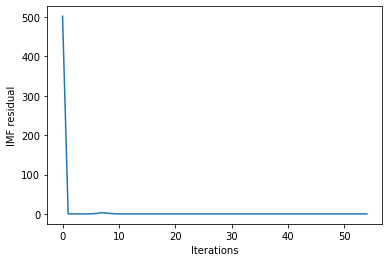

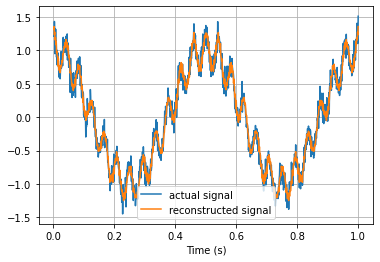

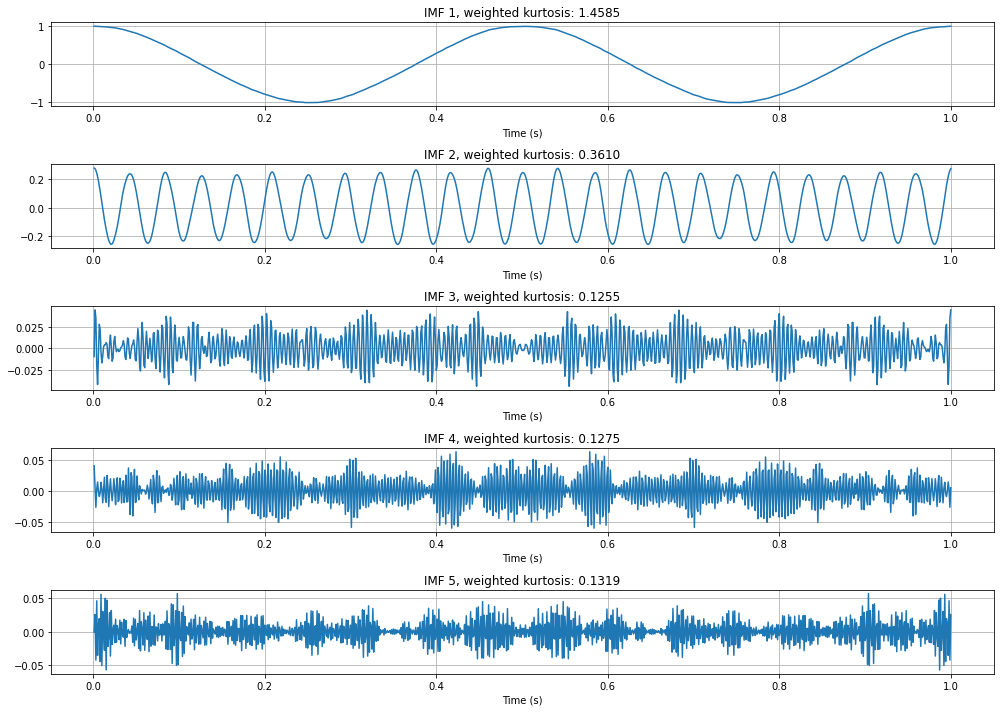

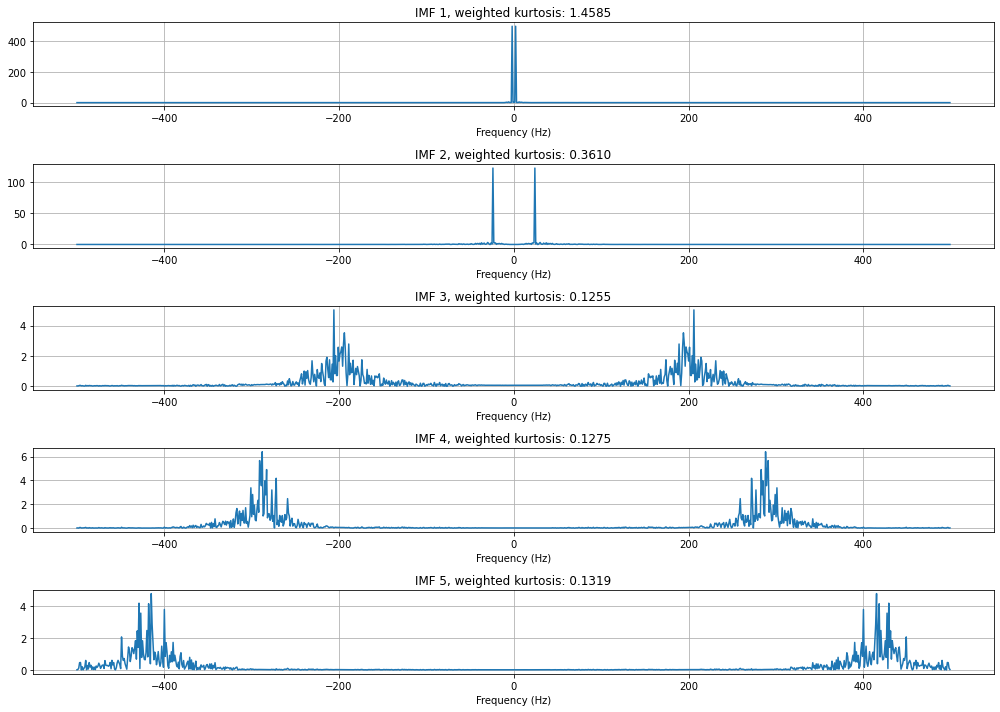

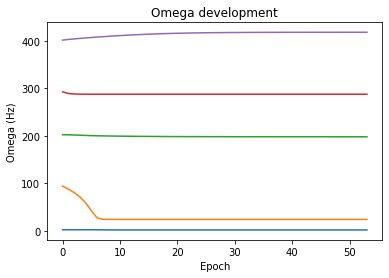

In [19]:
f1 = 2
f2 = 24
f3 = 288
Fs = 1000

time = np.arange(1, Fs + 1, 1) / Fs

v1 = np.cos(2 * np.pi * f1 * time)
v2 = 1/4 * np.cos(2 * np.pi * f2 * time)
v3 = 1/16 * np.cos(2 * np.pi * f3 * time)

x4 = v1 + v2 + v3 + np.random.randn(len(time)) * 0.1

VMD_instance = variational_mode_decomposition(alpha = 1000, 
                                              K = 5,
                                              tau = 0, 
                                              DC = False, 
                                              init = 1, 
                                              n_iter = 1000,
                                              tol = 1e-8,
                                             memory_flag = True).fit(x4)

IMF, U_IMF, Omega = VMD_instance.u, VMD_instance.u_hat, VMD_instance.omega

weighted_kurtosis = VMD_instance.wki
kurtosis = VMD_instance.kurtosis_IMFs
correlation = VMD_instance.corr_coeff_IMFs

print("\nKurtosis:\n{}\n\nCorrelation:\n{}\n\nWeighted kurtosis:\n{}\n".format(kurtosis, correlation, weighted_kurtosis))

plt.figure()
plt.plot(VMD_instance.imf_residual)
plt.xlabel("Iterations")
plt.ylabel("IMF residual")
plt.show()

plt.figure()
plt.plot(time, x4, label = "actual signal")
plt.plot(time, np.sum(IMF, axis = 1), label = "reconstructed signal")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.show()

fig, ax = plt.subplots(IMF.shape[1], 1, figsize = (14, 10))
ax = ax.flatten()
for i in range(IMF.shape[1]):
    ax[i].plot(time, IMF[:, i])
    ax[i].set_title("IMF {}, weighted kurtosis: {:.4f}".format(i + 1, weighted_kurtosis[i]))
    ax[i].grid()
    ax[i].set_xlabel("Time (s)")
    
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(IMF.shape[1], 1, figsize = (14, 10))
ax = ax.flatten()
#plt.semilogy(np.fft.fftshift(np.fft.fftfreq(len(time), 1/Fs)), np.abs(np.fft.fftshift(np.fft.fft(x4))), label = "actual signal")
for i in range(U_IMF.shape[1]):
    ax[i].plot(np.fft.fftshift(np.fft.fftfreq(len(time), 1/Fs)), np.abs(U_IMF[:, i]))
    ax[i].set_title("IMF {}, weighted kurtosis: {:.4f}".format(i + 1, weighted_kurtosis[i]))
    ax[i].grid()
    ax[i].set_xlabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

plt.figure()
plt.title("Omega development")
for i in range(Omega.shape[1]):
    plt.plot(Omega[:, i] * Fs, label = r"$\omega_{}$".format("{" + str(i) + "}"))

plt.ylabel("Omega (Hz)")
plt.xlabel("Epoch")
plt.show()

### Test on an actual signal

In [4]:
data_dir = "D:/PhD_Files/Datasets/Phenomenological/Dataset3/"
data_dict1 = io.loadmat(data_dir + "Exp1_H_R0001.mat")
data_dict2 = io.loadmat(data_dir + "Exp1_Uh_R0340.mat")

signal = data_dict2['x_total'][0, :] / 4000
Fs = 25e3
time = np.arange(len(signal)) / Fs
#signal2 = data_dict2['x_total'][0, :]

VMD_instance = variational_mode_decomposition(alpha = 1000, 
                                              K = 5,
                                              tau = 0, 
                                              DC = False, 
                                              init = 1, 
                                              n_iter = 1000,
                                              tol = 1e-6).optimise(signal, 
                                                                   K_range = [2, 9], 
                                                                   alpha_range = [1000, 10000], 
                                                                   index_type = "kurtosis")

t0 = time_pkg.time()
IMF, U_IMF, Omega = VMD_instance.u, VMD_instance.u_hat, VMD_instance.omega
print("Fitted in {:.5f} seconds".format(time_pkg.time() - t0))

weighted_kurtosis = VMD_instance.wki
kurtosis = VMD_instance.kurtosis_IMFs
correlation = VMD_instance.corr_coeff_IMFs

print("\nKurtosis:\n{}\n\nCorrelation:\n{}\n\nWeighted kurtosis:\n{}\n".format(kurtosis, correlation, weighted_kurtosis))

plt.figure()
plt.plot(time, signal, label = "actual signal")
plt.plot(time, np.sum(IMF, axis = 1), label = "reconstructed signal")
plt.legend()
plt.grid()
plt.show()

fig, ax = plt.subplots(IMF.shape[1], 1, figsize = (14, 10))
ax = ax.flatten()
for i in range(IMF.shape[1]):
    ax[i].plot(IMF[:, i])
    ax[i].set_title("IMF {}, weighted kurtosis: {:.4f}".format(i + 1, weighted_kurtosis[i]))
    ax[i].grid()
    
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(IMF.shape[1], 1, figsize = (14, 10))
ax = ax.flatten()
#plt.semilogy(np.fft.fftshift(np.fft.fftfreq(len(time), 1/Fs)), np.abs(np.fft.fftshift(np.fft.fft(x4))), label = "actual signal")
for i in range(U_IMF.shape[1]):
    ax[i].plot(np.fft.fftshift(np.fft.fftfreq(len(time), 1/Fs)), np.abs(U_IMF[:, i]))
    ax[i].set_title("IMF {}, weighted kurtosis: {:.4f}".format(i + 1, weighted_kurtosis[i]))
    ax[i].grid()
    ax[i].set_xlabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(IMF.shape[1], 1, figsize = (14, 10))
ax = ax.flatten()
#plt.semilogy(np.fft.fftshift(np.fft.fftfreq(len(time), 1/Fs)), np.abs(np.fft.fftshift(np.fft.fft(x4))), label = "actual signal")
for i in range(U_IMF.shape[1]):
    
    freq = np.fft.fftfreq(len(time), 1/Fs)
    vals = 2 / len(time) * np.abs(np.fft.fft(IMF[:, i]**2))
    
    ax[i].plot(freq[:len(time)//2], vals[:len(time)//2])
    ax[i].set_title("IMF {}, weighted kurtosis: {:.4f}".format(i + 1, weighted_kurtosis[i]))
    ax[i].grid()
    ax[i].set_xlabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

plt.figure()
plt.title("Omega development")
for i in range(Omega.shape[1]):
    plt.plot(Omega[:, i] * Fs, label = r"$\omega_{}$".format("{" + str(i) + "}"))

plt.ylabel("Omega (Hz)")
plt.xlabel("Epoch")
plt.show()

Starting run for K = 2, alpha = 1000.00 parameters...
Terminated after 25 iterations (uDiff = 9.533083751781202e-07)
Converged: True
Starting run for K = 3, alpha = 1000.00 parameters...
Terminated after 466 iterations (uDiff = 9.734189229809875e-07)
Converged: True
Starting run for K = 4, alpha = 1000.00 parameters...
Terminated after 152 iterations (uDiff = 9.627047135238657e-07)
Converged: True
Starting run for K = 5, alpha = 1000.00 parameters...
Terminated after 263 iterations (uDiff = 9.929234099535625e-07)
Converged: True
Starting run for K = 6, alpha = 1000.00 parameters...
Terminated after 512 iterations (uDiff = 9.768628024126692e-07)
Converged: True
Starting run for K = 7, alpha = 1000.00 parameters...
Terminated after 277 iterations (uDiff = 9.869808502830894e-07)
Converged: True
Starting run for K = 8, alpha = 1000.00 parameters...


KeyboardInterrupt: 

## Multivariate Variational Mode Decomposition

In [5]:
class multivariate_variational_mode_decomposition(object):
    
    def __init__(self, alpha, K, tau, DC = False, init = 1, n_iter = 500, tol = 1e-6, memory_flag = True):
        
        self.alpha = alpha #balancing parameter
        self.K = K #Number of IMFs/number of modes to be recovered
        self.tau = tau #tau = time-step dual ascent
        self.DC = DC # DC = True if the first mode is a DC component
        self.init = init #Select how center frequencies are initialised, 
        self.n_iter = n_iter #maximum number of iterations to perform
        self.tol = tol #iteration tolerance on updates
        self.eps = 2.220446049250313e-016
        self.memory_flag = memory_flag #If True, only store 2 iterations and just reuse the matrices (only applied to u_hat_plus)

    def MVMD(self, signals):

        Alpha = np.ones(self.K) * self.alpha #balancing parameter
        
        #original parameters
        save_T, self.n_features = signals.shape

        Fs = 1/save_T

        #Mirror signal
        T = save_T

        f = np.zeros((2 * T, self.n_features))

        for c in range(self.n_features):
            f_mirror = np.zeros(2 * T)
            f_mirror[:T//2] = signals[ : T // 2, c][::-1]
            f_mirror[T//2 : 3 * T //2] = signals[:, c]
            f_mirror[3 * T //2 :] = signals[T//2 :, c][::-1]

            f[:, c] = f_mirror

        #Extend time domain
        T *= 2
        t = np.arange(1, T + 1, 1) / T

        #spectral discretisation
        freqs = t - 0.5 - 1/T

        #calculate spectral information for each signal
        f_hat_plus = np.zeros((T, self.n_features),dtype=np.complex_)

        for c in range(self.n_features):
            f_hat = np.fft.fftshift((np.fft.fft(f[:, c])))
            f_hat_plus[:, c] = f_hat

        #Turn off one half
        f_hat_plus[:T//2, :] = 0
        
        #Generate storage matrices
        
        omega_plus = np.zeros((self.n_iter, self.K))

        if self.init == 0:
            pass #all omegas are zero

        elif self.init == 1:
            omega_plus[0, :] = [(0.5 / self.K)*(i) for i in range(self.K)] #all omegas are uniformly distributed

        elif self.init == 2:
            omega_plus[0, :] = np.sort(np.exp(np.log(Fs) + (np.log(0.5 / Fs))) * np.random.random(size = self.K)) #all omegas are randomly selected in [0, 1]
        
        else:
            print("Invalid init ({}) entered.".format(self.init))
            raise SystemExit
        
        if self.DC:
            omega_plus[0, 0] = 0
        
        
        if self.memory_flag:
            #Store u_hat in frequency (complex) domain for all iterations
            u_hat_plus = np.zeros((3, self.n_features, len(freqs), self.K),dtype=np.complex_) #3 because first iteration is out of the loop
        
        else:
            #Store u_hat in frequency (complex) domain for all iterations
            u_hat_plus = np.zeros((self.n_iter, self.n_features, len(freqs), self.K),dtype=np.complex_) 

        #Set up lambda variables
        lambda_hat = np.zeros((self.n_iter, self.n_features, len(freqs)), dtype=np.complex_)

        #initialise other stuff for loops
        uDiff = np.inf
        n = 0 #global counter
        n_memory = 0 #if memory_flag = False, n = n_global
        sum_uk = np.zeros_like(f, dtype=np.complex_)
        uDiff_list = []

        while uDiff > self.tol and n <= self.n_iter - 2:


            ##################
            #U update
            ##################
            for c in range(self.n_features):
                k = 0
                #Think about loop restart (all zero initially)
                #You will have subracted u_hat_plus[K], so add it back on and then subtract u_hat_plus[0]

                sum_uk[:, c] += u_hat_plus[n_memory, c, :, self.K - 1] - u_hat_plus[n_memory, c, :, k] 

                #U update @ k = 0
                u_hat_plus[n_memory + 1, c, :, k] = (f_hat_plus[:, c] - sum_uk[:, c] - lambda_hat[n, c, :] / 2) / (1 +  2 * Alpha[k] * (freqs - omega_plus[n, k])**2)

                for k in range(1, self.K, 1):

                    sum_uk[:, c] += u_hat_plus[n_memory + 1, c, :, k - 1] - u_hat_plus[n_memory, c, :, k]

                    #U update @ k = 0
                    u_hat_plus[n_memory + 1, c, :, k] = (f_hat_plus[:, c] - sum_uk[:, c] - lambda_hat[n, c, :] / 2) / (1 + 2 * Alpha[k] * (freqs - omega_plus[n, k])**2)

            ##################
            #OMEGA update
            ##################
            for k in range(self.K):
                omega_term = 0

                #Omega update @ k = 0 #freqs[T // 2 : T] is the positive half of the integration
                for c in range(self.n_features):
                    upper_term = np.sum(freqs[T//2 :] * (np.abs(u_hat_plus[n_memory + 1, c, T//2 :, k])**2))
                    lower_term = np.sum(np.abs(u_hat_plus[n_memory + 1, :, T // 2 :, k])**2) #Sum through all C
                    omega_term +=  upper_term / lower_term

                if k == 0 and self.DC:
                    omega_term = 0


                omega_plus[n + 1, k] = omega_term

            ##############
            #Dual ascent
            ##############
            for c in range(self.n_features):
                lambda_hat[n + 1, c, :] = lambda_hat[n, c, :] + self.tau * (np.sum(u_hat_plus[n_memory + 1, c, :, :], axis = 1) - f_hat_plus[:, c])

            #loop counter 
            n += 1
            n_memory += 1

            #convergence
            uDiff = self.eps

            for k in range(self.K):
                for c in range(self.n_features):
                    uDiff += 1 / T * np.sum(np.abs(u_hat_plus[n_memory, c, :, k] - u_hat_plus[n_memory - 1, c, :, k])**2)
            
            uDiff_list.append(uDiff)
            
            #Memory checks
            if self.memory_flag and n != 0 and (n_memory) % 2 == 0:
                
                #reset n_memory
                n_memory = 0
                
                #store final u_hat_pluse iteration in u_hat_plus_new
                u_hat_plus_new = np.zeros((3, self.n_features, len(freqs), self.K),dtype=np.complex_)
                u_hat_plus_new[0, :, :, :] = u_hat_plus[-1, :, :, :]
                
                #Overwrite u_hat_plus
                u_hat_plus = u_hat_plus_new

        #Clean up and post-processing
        self.imf_residual = np.array(uDiff_list)
        
        if self.memory_flag:
            N = min(self.n_iter, n)
            N_memory = n_memory #use last computation of u_hat_plus
        
        else:
            N = min(self.n_iter, n)
            N_memory = N #No difference between N and N_memory
        
        if N + 1 == self.n_iter or uDiff > self.tol:
            self.converged = False
        
        else:
            self.converged = True
        
        print("Terminated after {} iterations (uDiff = {})".format(N + 1, uDiff))
        print("Converged: {}".format(self.converged))

        #Store important omega terms
        omega = omega_plus[1:N, :]

        #Reconstruct signals from frequency
        u_hat = np.zeros((self.n_features, T, self.K),dtype=np.complex_)
        u = np.zeros((self.n_features, T // 2, self.K))
        
        for k in range(self.K): #Take u_i[positive half] and make properly defined
            
            for c in range(self.n_features):
            
                #Arrange first half
                u_hat[c, T//2:, k] = u_hat_plus[N_memory, c, T//2:, k]
                #Arrange second half
                u_hat[c, range(T//2, 0, -1), k] = u_hat_plus[N_memory, c, T//2:, k] #compute conjegate and reverse
                #Set first term
                u_hat[c, 0, k] = np.conjugate(u_hat_plus[N_memory, c, -1, k]) #Compute starting term
                
                #Shift, compute IFFT and then select non-mirrored bit!
                u[c, :, k] = np.real(np.fft.ifft(np.fft.ifftshift(u_hat[c, :, k])))[T//4 : 3*T//4]

        #Recompute u_hat
        u_hat = np.zeros((self.n_features, T // 2, self.K),dtype=np.complex_)
        
        for c in range(self.n_features):
            for k in range(self.K):
                u_hat[c, :, k] = np.fft.fftshift(np.fft.fft(u[c, :, k]))

        return u, u_hat, omega
    
    def get_params(self):
        
        return {"K":self.K, "alpha":self.alpha}
    
    def set_params(self, dict_params):
        
        self.K = dict_params["K"]
        self.alpha = dict_params["alpha"]
    
    def fit(self, X):
        
        #Determine IMFs
        self.u, self.u_hat, self.omega = self.MVMD(X)
        
        #Calculate kurtosis
        self.kurtosis_IMFs = self.calculate_kurtosis(self.u)
        self.corr_coeff_IMFs = self.calculate_correlation(X, self.u)
        self.wki = self.kurtosis_IMFs * np.abs(self.corr_coeff_IMFs)
        self.opt_index = np.argmax(self.wki)
        
        return self
    
    def optimise(self, X, K_range = [2, 7], alpha_range = 1000, index_type = "kurtosis"):
        Nk = int(np.diff(K_range) + 1)
        
        #Initialise parameter grid
        
        if type(alpha_range) == int:
            grid_params = np.ones((Nk, 2))
            grid_params[:, 0] = np.arange(K_range[0], K_range[1] + 1, 1)
            grid_params[:, 1] *= alpha_range
        
        else:
            X_params, Y_params =np.meshgrid(np.arange(K_range[0], K_range[1] + 1, 1),
                                            np.linspace(alpha_range[0], alpha_range[1], Nk))
            
            grid_params = np.hstack((X_params.reshape(-1, 1), Y_params.reshape(-1, 1)))
            
        #initialise optimal hyper-parameters
        opt_val = -np.inf
        opt_index = 0
        results_list = []
        
        for i in range(grid_params.shape[0]):
            
            param_iter_dict = {"K":int(grid_params[i, 0]), "alpha":grid_params[i, 1]}
            print("Starting run for K = {}, alpha = {:.2f} parameters...".format(param_iter_dict["K"], param_iter_dict["alpha"]))
            
            #Set the parameters
            self.set_params(param_iter_dict)
            
            #optimise the model
            self.fit(X)
            
            iter_results = {"u":self.u,
                            "u_hat":self.u_hat,
                            "omega":self.omega,
                            "kurtosis_IMFs":self.kurtosis_IMFs,
                            "corr_coeff_IMFs":self.corr_coeff_IMFs,
                            "wki":self.wki,
                            "imf_residual":self.imf_residual,
                            "converged":self.converged}
            
            results_list.append(iter_results)
            
            if index_type == "kurtosis":
                max_val_iter = np.max(self.kurtosis_IMFs)
                    
            elif index_type == "correlation":
                max_val_iter = np.max(self.corr_coeff_IMFs)

            elif index_type == "wki":
                max_val_iter = np.max(self.wki)
                
            if opt_val < max_val_iter:
                opt_val = max_val_iter
                opt_index = i
                
        #Save parameters
        opt_params = {"K":int(grid_params[opt_index, 0]), "alpha":grid_params[opt_index, 1]}
        self.set_params(opt_params)
        
        print("Finished optimising hyper-parameters!")
        print(opt_params)
        
        #Restore optimal solution
        opt_dict = results_list[opt_index]
        
        self.u = opt_dict["u"]
        self.u_hat = opt_dict["u_hat"]
        self.omega = opt_dict["omega"]
        self.kurtosis_IMFs = opt_dict["kurtosis_IMFs"]
        self.corr_coeff_IMFs = opt_dict["corr_coeff_IMFs"]
        self.wki = opt_dict["wki"]
        self.imf_residual = opt_dict["imf_residual"]
        self.converged = opt_dict["converged"]
        
        return self
    
    def transform(self, index_type = "kurtosis"):
        
        signal_list = []
        
        if index_type == "kurtosis":
            metric_mat = self.kurtosis_IMFs
            
        elif index_type == "correlation":
            metric_mat = self.corr_coeff_IMFs
        
        elif index_type == "wki":
            metric_mat = self.wki
        
        else:
            print("Invalid index type ({}) entered.".format(index_type))
        
        for c in range(self.n_features):
                
            pos_max = np.argmax(metric_mat[:, c])
            signal_list.append(self.u[c, :, [pos_max]])
        
        return np.vstack(signal_list).T
        
    @staticmethod
    def calculate_kurtosis(u):
        #Perform calculation for each dimension
        
        n_features, len_time, K = u.shape
        
        Kurt = np.zeros((K, n_features))
        
        for c in range(n_features):
            
            u_slice = u[c, :, :]
            
            mean = np.mean(u_slice, axis = 0)
            
            N = len_time

            Top = np.sum((u_slice - mean)**4, axis = 0)
            Bottom = np.sum((u_slice - mean)**2, axis = 0)**2
            Kurt[:, c] = N * ( Top )/( Bottom )
            
        return Kurt #Maximum for all IMFs
    
    @staticmethod
    def calculate_correlation(signals, u):
        
        n_features, len_time, K = u.shape
        
        corr_array = np.zeros((K, n_features))
        
        for k in range(K):
            
            for c in range(n_features):
            
                signal = signals[:, c]

                corr_array[k, c] = np.corrcoef(signal, u[c, :, k])[0, 1]

        return corr_array

### Test on toy signals

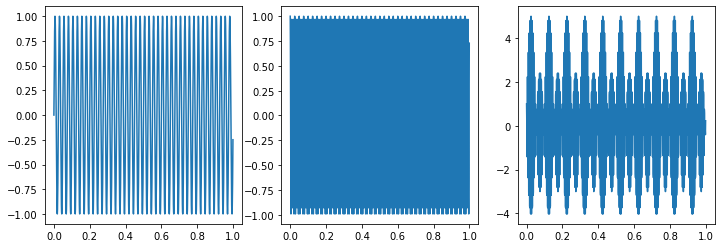

(3, 1000)
[[1.97652657 0.65047027 1.42675252]
 [0.65047027 0.46553047 0.29744244]
 [1.42675252 0.29744244 1.15712185]]


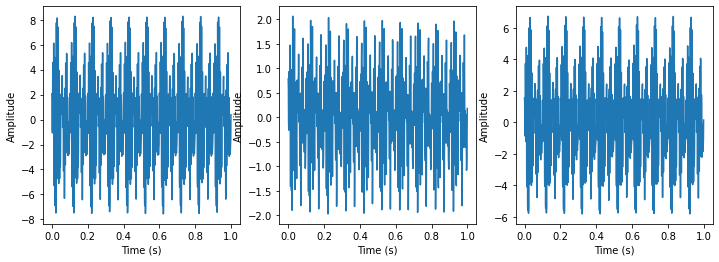

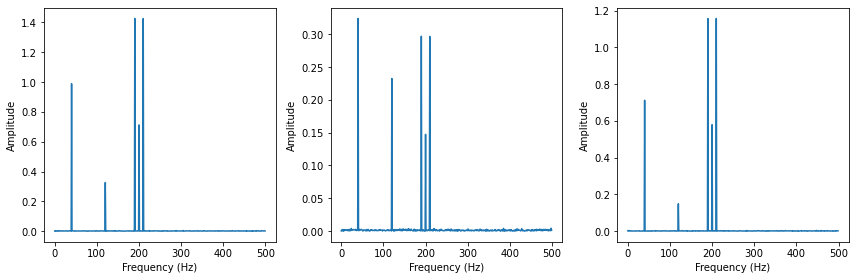

Terminated after 49 iterations (uDiff = 8.737739468953777e-07)
Converged: True

Kurtosis:
[[44.84680411 11.81257721 44.54525196]
 [ 1.50151377  1.50185169  1.50464529]
 [24.36042379 22.46698321 24.10318297]
 [27.33795106 26.73760256 27.63787592]
 [ 1.50161296  1.50224587  1.50169745]]

Correlation:
[[ 1.55527646e-04  1.24974650e-02  2.75291742e-04]
 [ 1.37020674e-01  3.88664894e-01  7.92016149e-02]
 [ 3.36265453e-02  2.91998498e-02  3.54202046e-02]
 [-7.51641490e-03 -3.92917478e-03 -8.44288129e-03]
 [ 2.93833409e-01  2.41639383e-01  3.02003005e-01]]

Weighted kurtosis:
[[0.00697492 0.14762727 0.01226294]
 [0.20573843 0.58371703 0.11917034]
 [0.81915689 0.65603254 0.85373967]
 [0.20548338 0.10505671 0.23334331]
 [0.44122406 0.36300177 0.45351714]]



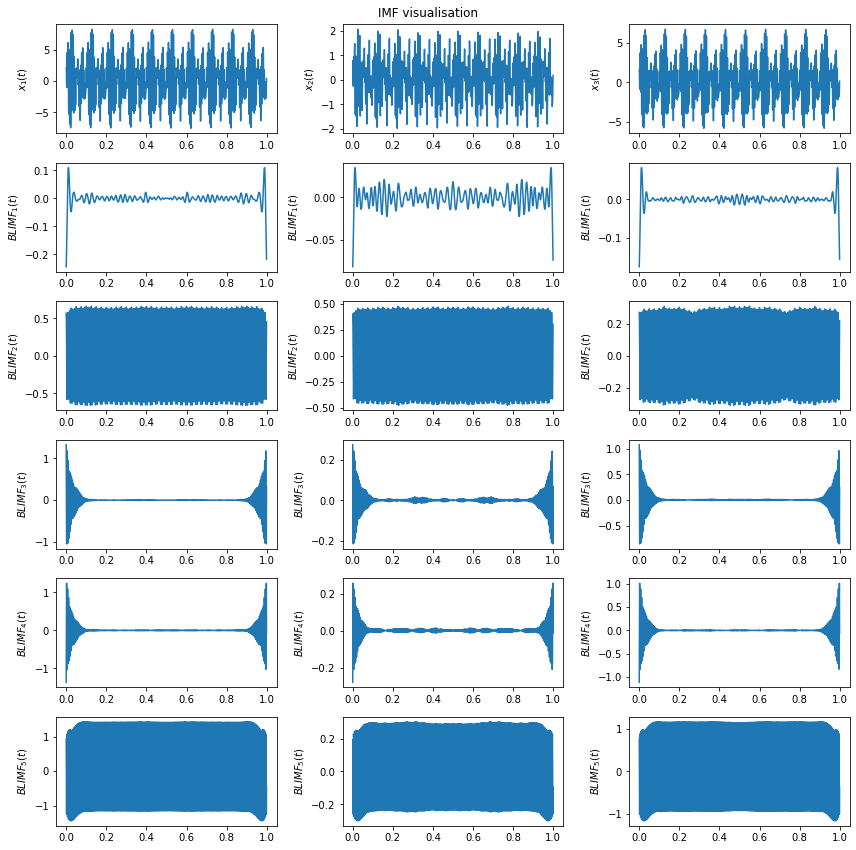

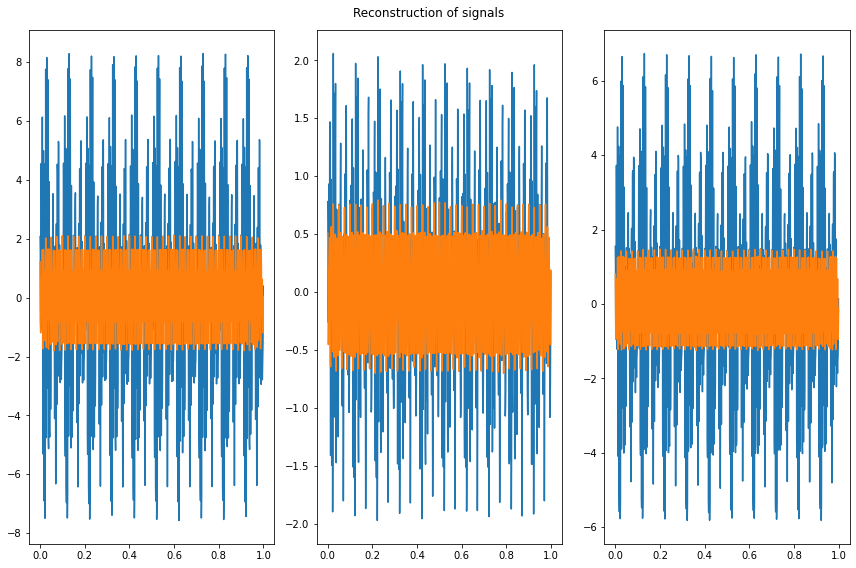

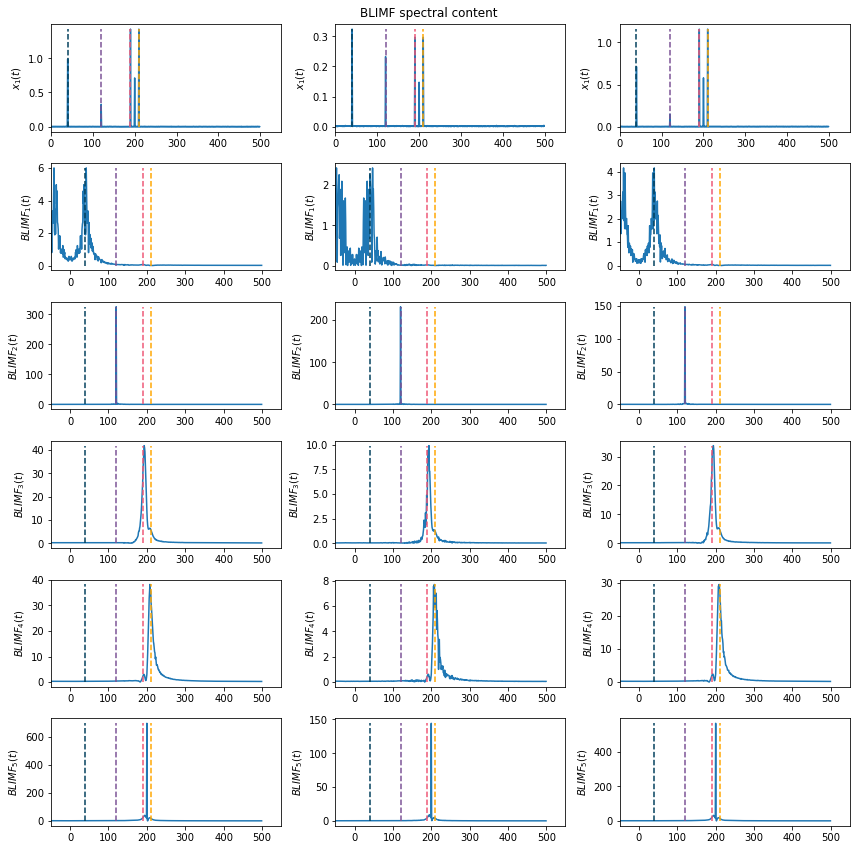

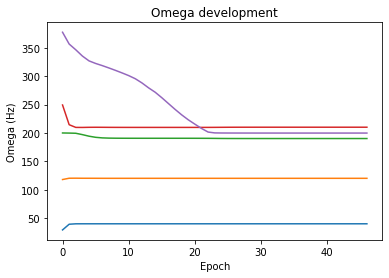

In [22]:
T = 1
Fs = 1000
f1 = 40
f2 = 120
f3 = 200
f4 = 10

time = np.arange(0, T, 1/Fs)

x1 = np.sin(2 * np.pi * f1 * time)
x2 = np.cos(2 * np.pi * f2 * time)
x3 = np.cos(2 * np.pi * f3 * time) * (1 + 4 * np.sin(2 * np.pi * f4 * time))

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax = ax.flatten()
ax[0].plot(time, x1)
ax[1].plot(time, x2)
ax[2].plot(time, x3)
plt.show()

X = np.vstack((x1, x2, x3))#
print(X.shape)

R = np.random.rand(3, 3)
R = np.dot(R, R.T)

print(R)

S = np.dot(R, X) + np.random.randn(3, len(time)) * 0.05
S = S.T

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax = ax.flatten()
ax[0].plot(time, S[:, 0])
ax[1].plot(time, S[:, 1])
ax[2].plot(time, S[:, 2])
for axs in ax:
    axs.set_xlabel("Time (s)")
    axs.set_ylabel("Amplitude")
plt.show()

freq = np.fft.fftfreq(Fs, 1/Fs)[:Fs//2]

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax = ax.flatten()
ax[0].plot(freq, 1 / Fs * np.abs(np.fft.fft(S[:, 0]))[:Fs//2])
ax[1].plot(freq, 1 / Fs * np.abs(np.fft.fft(S[:, 1]))[:Fs//2])
ax[2].plot(freq, 1 / Fs * np.abs(np.fft.fft(S[:, 2]))[:Fs//2])

for axs in ax:
    axs.set_xlabel("Frequency (Hz)")
    axs.set_ylabel("Amplitude")
fig.tight_layout()
plt.show()


##########################
#RUN MVMD
##########################

MVMD_instance = multivariate_variational_mode_decomposition(alpha = 4000, 
                                                          K = 5,
                                                          tau = 0, 
                                                          DC = False, 
                                                          init = 1, 
                                                          n_iter = 1000,
                                                          tol = 1e-6,
                                                          memory_flag = True).fit(S)

IMF, U_IMF, Omega = MVMD_instance.u, MVMD_instance.u_hat, MVMD_instance.omega

weighted_kurtosis = MVMD_instance.wki
kurtosis = MVMD_instance.kurtosis_IMFs
correlation = MVMD_instance.corr_coeff_IMFs

print("\nKurtosis:\n{}\n\nCorrelation:\n{}\n\nWeighted kurtosis:\n{}\n".format(kurtosis, correlation, weighted_kurtosis))

#############################
#Visualise IMFs
#############################

fig, ax = plt.subplots(MVMD_instance.K + 1, S.shape[1], figsize = (12, 12))
fig.suptitle("IMF visualisation")
ax = ax.flatten()

ax[0].plot(time, S[:, 0])
ax[0].set_ylabel(r"$x_1(t)$")

ax[1].plot(time, S[:, 1])
ax[1].set_ylabel(r"$x_2(t)$")

ax[2].plot(time, S[:, 2])
ax[2].set_ylabel(r"$x_3(t)$")

cnt = 3

for k in range(MVMD_instance.K):
    for c in range(S.shape[1]):
        ax[cnt].plot(time, IMF[c, :, k])
        ax[cnt].set_ylabel(r"$BLIMF_{}(t)$".format("{" + str(k + 1) + "}"))
        #ax[cnt].axis([0, 0.1, None, None])
        cnt += 1
        
plt.tight_layout()
plt.show()

#############################
#Reconstruction of multivariate signals
#############################
fig, ax = plt.subplots(1, S.shape[1], figsize = (12, 8))
fig.suptitle("Reconstruction of signals")
ax = ax.flatten()

ax[0].plot(time, S[:, 0])
ax[1].plot(time, S[:, 1])
ax[2].plot(time, S[:, 2])

cnt = 0
for c in range(S.shape[1]):
    signal_recon = 0
    for k in range(MVMD_instance.K):
        
        signal_recon += IMF[c, :, k]
    
    ax[cnt].plot(time, signal_recon)
    cnt += 1

fig.tight_layout()
plt.show()


#############################
#Frequency content of IMFs
#############################
freq = np.fft.fftfreq(Fs, 1/Fs)

fig, ax = plt.subplots(MVMD_instance.K + 1, S.shape[1], figsize = (12, 12))
fig.suptitle("BLIMF spectral content")
ax = ax.flatten()

for cnt in range(S.shape[1]):
    
    amp = 1 / Fs * np.abs(np.fft.fft(S[:, cnt]))
    
    ax[cnt].plot(freq, amp)
    ax[cnt].set_ylabel(r"$x_1(t)$")
    
    ax[cnt].plot([f1, f1], [0, np.max(amp)], color = "#003f5c", linestyle = "--")
    ax[cnt].plot([f2, f2], [0, np.max(amp)], color = "#7a5195", linestyle = "--")
    ax[cnt].plot([f3 - f4, f3 - f4], [0, np.max(amp)], color = "#ef5675", linestyle = "--")
    ax[cnt].plot([f3 + f4, f3 + f4], [0, np.max(amp)], color = "#ffa600", linestyle = "--")
    ax[cnt].axis([0, None, None, None])


cnt = 3
for k in range(MVMD_instance.K):
    for c in range(S.shape[1]):
    
        amp = np.abs(U_IMF[c, :, k])
        ax[cnt].plot(np.fft.fftshift(freq), amp)
        ax[cnt].set_ylabel(r"$BLIMF_{}(t)$".format("{" + str(k + 1) + "}"))
        
        ax[cnt].plot([f1, f1], [0, np.max(amp)], color = "#003f5c", linestyle = "--")
        ax[cnt].plot([f2, f2], [0, np.max(amp)], color = "#7a5195", linestyle = "--")
        ax[cnt].plot([f3 - f4, f3 - f4], [0, np.max(amp)], color = "#ef5675", linestyle = "--")
        ax[cnt].plot([f3 + f4, f3 + f4], [0, np.max(amp)], color = "#ffa600", linestyle = "--")
        ax[cnt].axis([-50, None, None, None])
        cnt += 1
        
plt.tight_layout()
plt.show()

########################
#Visualise omega training
########################
plt.figure()
plt.title("Omega development")
for i in range(Omega.shape[1]):
    plt.plot(Omega[:, i] * Fs, label = r"$\omega_{}$".format("{" + str(i) + "}"))

plt.ylabel("Omega (Hz)")
plt.xlabel("Epoch")
plt.show()

### Test on actual signal

Terminated after 855 iterations (uDiff = 9.96012029304941e-07)
Converged: True

Kurtosis:
[[1.56395068 1.56316019 1.56704529]
 [1.76353983 1.76059545 1.75255108]
 [3.04295664 2.97411019 2.90590712]
 [3.3271144  3.17128703 3.14601768]
 [2.73903498 2.9398755  3.60918995]
 [3.00779902 4.01194417 6.57083742]
 [2.89015657 3.107894   4.82213229]
 [3.05693002 2.9684842  3.29716464]
 [2.99105199 3.19915697 3.03465643]
 [3.28809456 2.94224209 3.13046498]]

Correlation:
[[0.54660418 0.53454857 0.51385318]
 [0.46024728 0.45279542 0.4440778 ]
 [0.14246509 0.14163761 0.14162274]
 [0.13958027 0.14281781 0.14374369]
 [0.13587874 0.14352498 0.15171853]
 [0.13068026 0.15548666 0.21030027]
 [0.13174971 0.14063956 0.16851136]
 [0.13500192 0.13601604 0.14229533]
 [0.13420013 0.1358684  0.1326822 ]
 [0.12214922 0.12473557 0.1196903 ]]

Weighted kurtosis:
[[0.85486197 0.83558505 0.8052312 ]
 [0.81166441 0.79718956 0.77826903]
 [0.43351508 0.42124587 0.41154252]
 [0.46439951 0.45291628 0.45222018]
 [0.372176

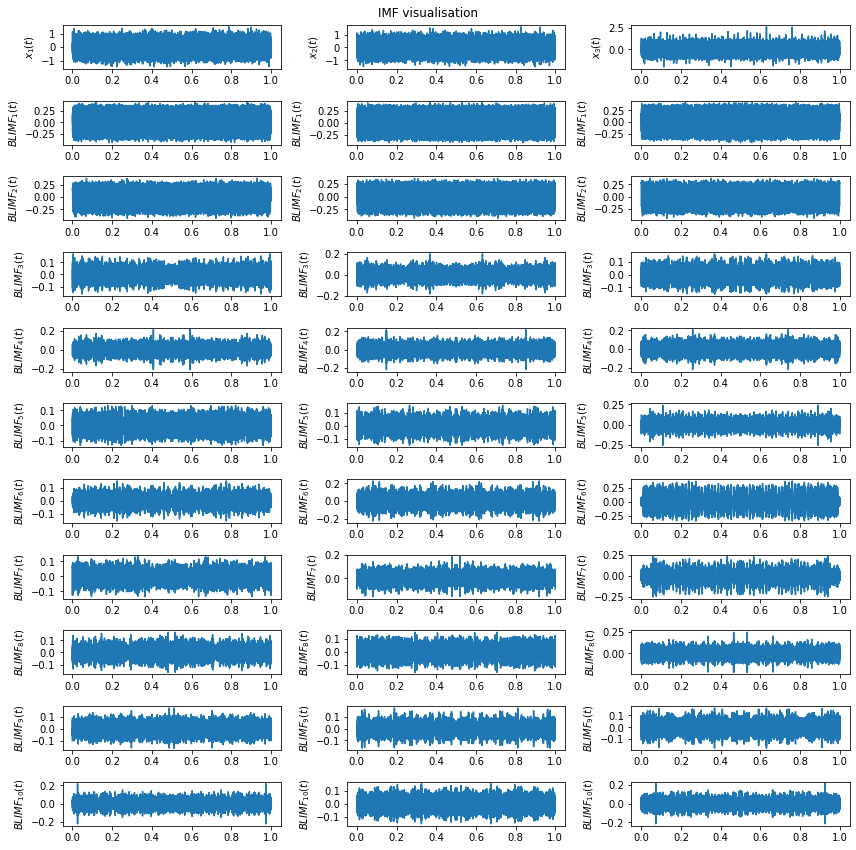

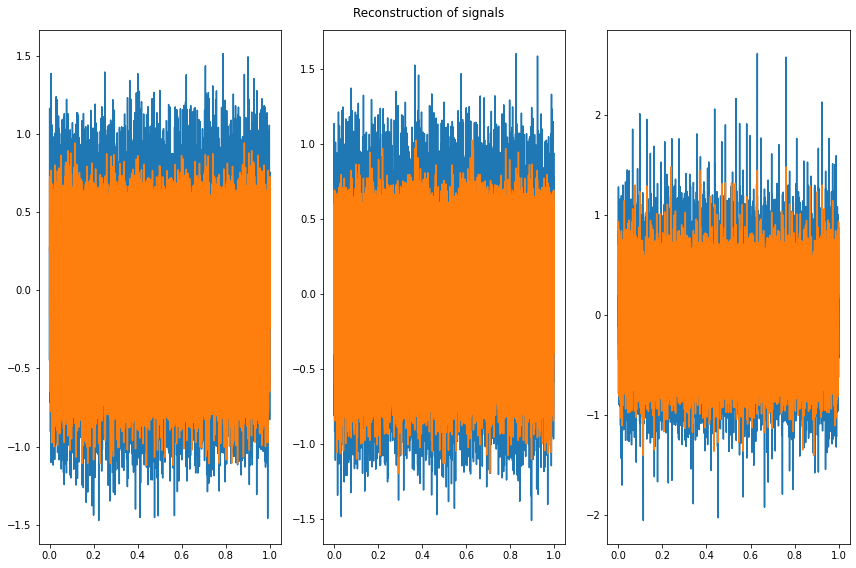

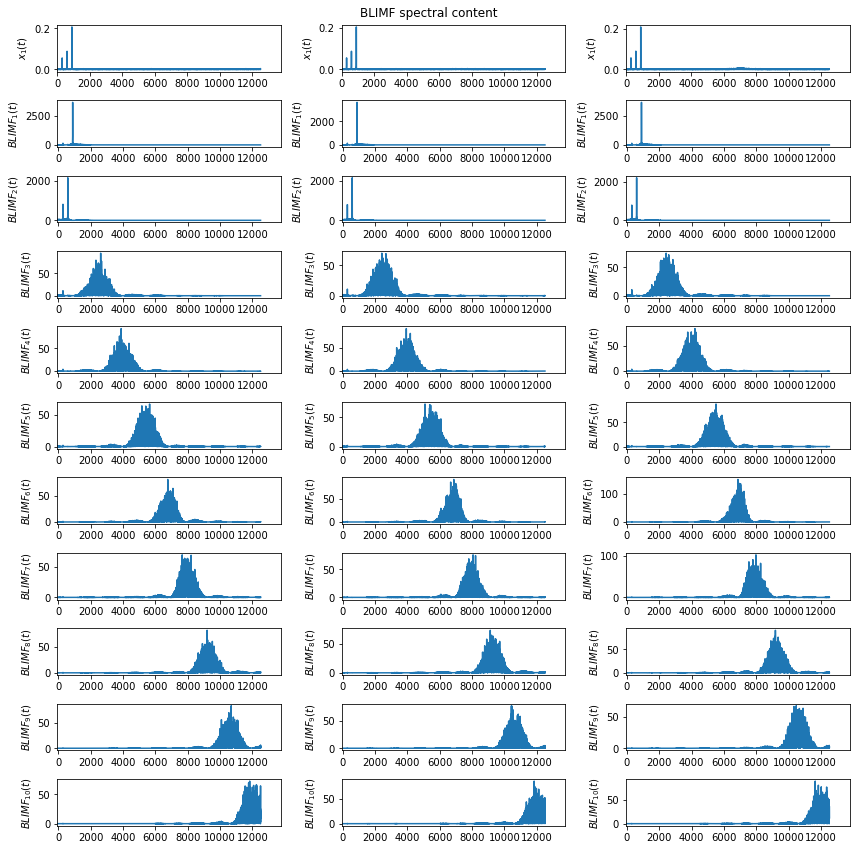

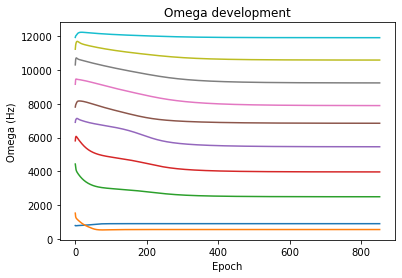

In [27]:
try_many_latent = False #If true, it will run off the latent data I have saved. If false, will use a

if not try_many_latent:
    data_dir = "D:/PhD_Files/Datasets/Phenomenological/Dataset3/"
    data_dict1 = io.loadmat(data_dir + "Exp1_H_R0001.mat")
    data_dict2 = io.loadmat(data_dir + "Exp1_Uh_R0300.mat")
    data_dict3 = io.loadmat(data_dir + "Exp1_Uh_R0340.mat")

    signal1 = data_dict1['x_total'][0, :] / 4000
    signal2 = data_dict2['x_total'][0, :] / 4000
    signal3 = data_dict3['x_total'][0, :] / 4000
    
    X = np.vstack((signal1, signal2, signal3)).T

else:
    Data_mat = np.load("test_latent_mat_320_352.npy")
    X = Data_mat[-1, :, :]
    print(X.shape)
    
Fs = 25e3
time = np.arange(X.shape[0]) / Fs

#X = np.dot(X, R)

MVMD_instance = multivariate_variational_mode_decomposition(alpha = 100, 
                                                              K = 10,
                                                              tau = 0, 
                                                              DC = False, 
                                                              init = 1, 
                                                              n_iter = 1000,
                                                              tol = 1e-6,
                                                              memory_flag = True).fit(X)#.optimise(X, 
                                                                                 #  K_range = [2, 6], 
                                                                                 #  alpha_range = 2000, 
                                                                                 #  index_type = "kurtosis")

IMF, U_IMF, Omega = MVMD_instance.u, MVMD_instance.u_hat, MVMD_instance.omega

weighted_kurtosis = MVMD_instance.wki
kurtosis = MVMD_instance.kurtosis_IMFs
correlation = MVMD_instance.corr_coeff_IMFs

print("\nKurtosis:\n{}\n\nCorrelation:\n{}\n\nWeighted kurtosis:\n{}\n".format(kurtosis, correlation, weighted_kurtosis))

#############################
#Visualise IMFs
#############################

fig, ax = plt.subplots(MVMD_instance.K + 1, X.shape[1], figsize = (12, 12))
fig.suptitle("IMF visualisation")
ax = ax.flatten()

for i in range(X.shape[1]):
    ax[i].plot(time, X[:, i])
    ax[i].set_ylabel(r"$x_{}(t)$".format(i + 1))

cnt = i + 1

for k in range(MVMD_instance.K):
    for c in range(X.shape[1]):
        ax[cnt].plot(time, IMF[c, :, k])
        ax[cnt].set_ylabel(r"$BLIMF_{}(t)$".format("{" + str(k + 1) + "}"))
        #ax[cnt].axis([0, 0.1, None, None])
        cnt += 1
        
plt.tight_layout()
plt.show()

#############################
#Reconstruction of multivariate signals
#############################
fig, ax = plt.subplots(1, X.shape[1], figsize = (12, 8))
fig.suptitle("Reconstruction of signals")
ax = ax.flatten()

for i in range(X.shape[1]):
    ax[i].plot(time, X[:, i])

cnt = 0

for c in range(X.shape[1]):
    signal_recon = 0
    for k in range(MVMD_instance.K):
        
        signal_recon += IMF[c, :, k]
    
    ax[cnt].plot(time, signal_recon)
    cnt += 1

fig.tight_layout()
plt.show()


#############################
#Frequency content of IMFs
#############################
freq = np.fft.fftfreq(X.shape[0], 1/Fs)

fig, ax = plt.subplots(MVMD_instance.K + 1, X.shape[1], figsize = (12, 12))
fig.suptitle("BLIMF spectral content")
ax = ax.flatten()

for cnt in range(X.shape[1]):
    
    amp = 1 / Fs * np.abs(np.fft.fft(X[:, cnt]))
    
    ax[cnt].plot(freq, amp)
    ax[cnt].set_ylabel(r"$x_1(t)$")

    ax[cnt].axis([0, None, None, None])


cnt += 1

for k in range(MVMD_instance.K):
    for c in range(X.shape[1]):
    
        #amp = 2 / X.shape[0] * np.abs(np.fft.fft(IMF[c, :, k]**2))
        #ax[cnt].plot(freq[:X.shape[0]//2], amp[:X.shape[0]//2])
        amp = np.abs(U_IMF[c, :, k])
        ax[cnt].plot(np.fft.fftshift(freq), amp)
        ax[cnt].set_ylabel(r"$BLIMF_{}(t)$".format("{" + str(k + 1) + "}"))
        
        #ax[cnt].plot([f1, f1], [0, np.max(amp)], color = "#003f5c", linestyle = "--")
        #ax[cnt].plot([f2, f2], [0, np.max(amp)], color = "#7a5195", linestyle = "--")
        #ax[cnt].plot([f3 - f4, f3 - f4], [0, np.max(amp)], color = "#ef5675", linestyle = "--")
        #ax[cnt].plot([f3 + f4, f3 + f4], [0, np.max(amp)], color = "#ffa600", linestyle = "--")
        ax[cnt].axis([-50, None, None, None])
        cnt += 1
        
plt.tight_layout()
plt.show()

########################
#Visualise omega training
########################
plt.figure()
plt.title("Omega development")
for i in range(Omega.shape[1]):
    plt.plot(Omega[:, i] * Fs, label = r"$\omega_{}$".format("{" + str(i) + "}"))

plt.ylabel("Omega (Hz)")
plt.xlabel("Epoch")
plt.show()

#### Test transformation

<IPython.core.display.Javascript object>


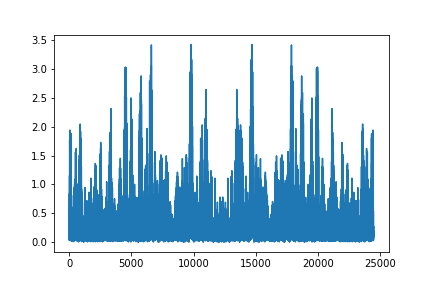

<IPython.core.display.Javascript object>


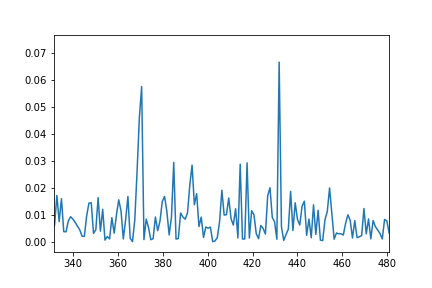

In [99]:
X_trans = MVMD_instance.transform()
X_trans = X_trans.T

R = np.sum(X_trans**2, axis = 1)

plt.figure()
plt.plot(R)
plt.show()

amp = 2/X_trans.shape[0] * np.abs(np.fft.fft(R - np.mean(R)))

plt.figure()
plt.plot(freq[:X_trans.shape[0] // 2], amp[:X_trans.shape[0] // 2])
plt.show()

### Run on VAE latent space

In [6]:
import os
import time as time_pkg
data_dir = "D:/PhD_Files/latent_evaluation/VAE latent/"

names = os.listdir(data_dir)

batch_size = 32
R_run = []

for i in range(0, 400, batch_size):
    
    start = i
    end = min(400, start + batch_size)
    
    data_mat = np.load(data_dir + "test_latent_mat_{}_{}.npy".format(start, end))
    
    for j in range(end - start):
        t0 = time_pkg.time()
        print("\n\nRunning signal {}...".format(start + j))
        
        latent_signals = data_mat[j, :, :]
        
        
        MVMD_instance = multivariate_variational_mode_decomposition(alpha = 1000, 
                                                              K = 6,
                                                              tau = 0, 
                                                              DC = False, 
                                                              init = 1, 
                                                              n_iter = 1000,
                                                              tol = 1e-6,
                                                              memory_flag = True).optimise(latent_signals, 
                                                                                   K_range = [2, 8], 
                                                                                   alpha_range = 2000, 
                                                                                   index_type = "kurtosis")
        
        X_trans = MVMD_instance.transform()
        print(X_trans.shape)
        R_local = np.sum(X_trans**2, axis = 1)
        
        R_run.append(R_local)
        
        print("Finished in: {}".format(time_pkg.time() - t0))
Rmat = np.array(R_run)
print(Rmat.shape)



Running signal 0...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 34 iterations (uDiff = 4.073360703558073e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 33 iterations (uDiff = 7.714708706701959e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 81 iterations (uDiff = 9.652820022882604e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 97 iterations (uDiff = 9.445700898188838e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 66 iterations (uDiff = 8.377477100914059e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 154 iterations (uDiff = 9.309900628293617e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 135 iterations (uDiff = 8.658736266274128e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8

Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 134 iterations (uDiff = 8.567211370091483e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 64.25750160217285


Running signal 8...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 34 iterations (uDiff = 6.090732218955587e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 32 iterations (uDiff = 7.877998148694309e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 84 iterations (uDiff = 8.082377949969923e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 54 iterations (uDiff = 8.446886909973762e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 148 iterations (uDiff = 9.161397023707685e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 9

Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 99 iterations (uDiff = 9.02132975246456e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 84 iterations (uDiff = 9.54971845497927e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 95 iterations (uDiff = 9.12015772276171e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 50.33350133895874


Running signal 16...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 35 iterations (uDiff = 9.58707750146375e-08)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 55 iterations (uDiff = 8.398792955488972e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 141 iterations (uDiff = 9.884511055392175e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 109 i

Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 107 iterations (uDiff = 6.247356321669965e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 83 iterations (uDiff = 8.75853519222125e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 140 iterations (uDiff = 9.442801362734914e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 56 iterations (uDiff = 7.608737746519695e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 145 iterations (uDiff = 8.774260556130996e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 62.838006019592285


Running signal 24...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 37 iterations (uDiff = 7.238350675669355e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after

Terminated after 34 iterations (uDiff = 8.904909068840919e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 57 iterations (uDiff = 9.688753569182732e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 225 iterations (uDiff = 8.851744860063242e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 139 iterations (uDiff = 9.281241645880969e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 138 iterations (uDiff = 9.269816798445815e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 392 iterations (uDiff = 9.749590346706282e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 113 iterations (uDiff = 8.58946836714243e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 111.83649945259094


Running si

Terminated after 113 iterations (uDiff = 9.091027930442244e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 60.62949538230896


Running signal 39...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 37 iterations (uDiff = 1.270700420198962e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 91 iterations (uDiff = 9.469482151980386e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 196 iterations (uDiff = 9.407395926242438e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 50 iterations (uDiff = 8.411677009763927e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 179 iterations (uDiff = 9.291276175880158e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 112 iterations (uDiff = 9.843616830925471e-07)
Conver

Terminated after 69 iterations (uDiff = 8.408066734275541e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 87 iterations (uDiff = 9.23928799437703e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 128 iterations (uDiff = 9.588093399597054e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 50.24000287055969


Running signal 47...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 35 iterations (uDiff = 3.211465161797188e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 28 iterations (uDiff = 8.215832632273011e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 64 iterations (uDiff = 6.722425930178631e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 67 iterations (uDiff = 8.453159669885939e-07)
Converged:

Terminated after 90 iterations (uDiff = 9.930100078037367e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 55 iterations (uDiff = 9.206218112242166e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 102 iterations (uDiff = 9.880135651147527e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 95 iterations (uDiff = 8.458720802576934e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 130 iterations (uDiff = 8.27234487941844e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 57.431501150131226


Running signal 55...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 33 iterations (uDiff = 9.026220627366239e-08)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 50 iterations (uDiff = 9.655474720373615e-07)
Converge

Terminated after 32 iterations (uDiff = 1.981961958202002e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 32 iterations (uDiff = 9.986952956671679e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 88 iterations (uDiff = 8.448957166286337e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 48 iterations (uDiff = 8.482771917265253e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 131 iterations (uDiff = 9.697803667790689e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 107 iterations (uDiff = 8.669305772233308e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 86 iterations (uDiff = 9.260706133150445e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 54.97450065612793


Running signa

Terminated after 82 iterations (uDiff = 7.789723127259131e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 76.59450840950012


Running signal 70...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 34 iterations (uDiff = 1.0283490305859541e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 39 iterations (uDiff = 7.296973660829298e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 88 iterations (uDiff = 8.551991957546748e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 55 iterations (uDiff = 8.205108991462783e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 76 iterations (uDiff = 9.297718864369857e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 124 iterations (uDiff = 8.479292311314381e-07)
Converge

Terminated after 127 iterations (uDiff = 9.851425304945269e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 106 iterations (uDiff = 9.59655684945558e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 95 iterations (uDiff = 9.909659696533837e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 58.187511682510376


Running signal 78...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 35 iterations (uDiff = 1.6254601699877137e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 43 iterations (uDiff = 8.959867652026471e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 104 iterations (uDiff = 8.13099724204945e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 51 iterations (uDiff = 8.089666043000717e-07)
Converg

Terminated after 91 iterations (uDiff = 7.410768237713456e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 80 iterations (uDiff = 9.183210546417173e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 66 iterations (uDiff = 9.452665549783922e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 182 iterations (uDiff = 9.054752442753902e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 111 iterations (uDiff = 9.40279943929713e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 61.86904048919678


Running signal 86...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 35 iterations (uDiff = 8.587878246264795e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 37 iterations (uDiff = 8.304865495090068e-07)
Converged

Terminated after 37 iterations (uDiff = 9.637775658991003e-08)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 34 iterations (uDiff = 7.301354232813322e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 79 iterations (uDiff = 7.509980023479476e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 112 iterations (uDiff = 9.691230087072702e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 76 iterations (uDiff = 8.060397877186423e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 65 iterations (uDiff = 7.484561087753228e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 258 iterations (uDiff = 9.686221675722616e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 76.29949975013733


Running signa

Terminated after 224 iterations (uDiff = 8.226756014414342e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 78.88381552696228


Running signal 101...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 37 iterations (uDiff = 1.045609863062485e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 31 iterations (uDiff = 8.783898712795983e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 80 iterations (uDiff = 8.817706662017743e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 122 iterations (uDiff = 9.990018778189703e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 69 iterations (uDiff = 9.2368495728762e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 125 iterations (uDiff = 8.6692205251079e-07)
Converged:

Terminated after 260 iterations (uDiff = 9.682902013330102e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 141 iterations (uDiff = 9.413575543596759e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 130 iterations (uDiff = 8.296189493010372e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 88.6332139968872


Running signal 109...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 36 iterations (uDiff = 4.977752243101295e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 32 iterations (uDiff = 7.323959478316978e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 84 iterations (uDiff = 8.537135064909492e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 138 iterations (uDiff = 9.693209906319354e-07)
Conver

Terminated after 90 iterations (uDiff = 9.352446348865234e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 70 iterations (uDiff = 7.842055924461636e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 104 iterations (uDiff = 8.81271142546974e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 50 iterations (uDiff = 8.272644492757374e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 174 iterations (uDiff = 9.460834277378757e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 60.76775646209717


Running signal 117...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 36 iterations (uDiff = 1.0567158871952731e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 38 iterations (uDiff = 7.567227306568334e-07)
Converg

Terminated after 34 iterations (uDiff = 1.3252099007522038e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 42 iterations (uDiff = 8.354727735160668e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 108 iterations (uDiff = 7.534756366535162e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 222 iterations (uDiff = 9.423836408110291e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 139 iterations (uDiff = 7.542948191145536e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 79 iterations (uDiff = 9.372711939850865e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 83 iterations (uDiff = 7.502162664285169e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 62.21249771118164


Running sig

Terminated after 129 iterations (uDiff = 9.560229669169791e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 54.692500829696655


Running signal 132...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 33 iterations (uDiff = 4.327595476170629e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 41 iterations (uDiff = 9.081267058506036e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 100 iterations (uDiff = 7.559267006818274e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 203 iterations (uDiff = 8.659645040248828e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 97 iterations (uDiff = 8.14665608686751e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 127 iterations (uDiff = 9.043538805624448e-07)
Conve

Terminated after 204 iterations (uDiff = 9.664265442868857e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 86 iterations (uDiff = 9.251424023577508e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 79 iterations (uDiff = 9.590109467849824e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 57.658262491226196


Running signal 140...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 34 iterations (uDiff = 8.168877438583514e-08)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 81 iterations (uDiff = 9.580757697841207e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 868 iterations (uDiff = 9.916280470370384e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 112 iterations (uDiff = 9.289015104840991e-07)
Conve

Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 119 iterations (uDiff = 8.53956045777519e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 194 iterations (uDiff = 9.841315303581368e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 149 iterations (uDiff = 9.105520036956073e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 110 iterations (uDiff = 9.529568399757282e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 134 iterations (uDiff = 7.382478131493689e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 73.89474058151245


Running signal 148...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 33 iterations (uDiff = 9.25088682541408e-08)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated afte

Terminated after 35 iterations (uDiff = 3.2085176285880353e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 39 iterations (uDiff = 8.382695666747758e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 89 iterations (uDiff = 8.169414741125927e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 53 iterations (uDiff = 8.630611758657707e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 167 iterations (uDiff = 9.456101538898636e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 158 iterations (uDiff = 9.627501808430913e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 98 iterations (uDiff = 8.089982361029964e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 62.927499771118164


Running sig

Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 172 iterations (uDiff = 7.768645219117494e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 92.63571286201477


Running signal 163...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 33 iterations (uDiff = 2.9518820008718205e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 64 iterations (uDiff = 8.770594158080284e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 307 iterations (uDiff = 9.61645678791732e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 145 iterations (uDiff = 9.296212469717303e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 190 iterations (uDiff = 9.788229312378737e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated aft

Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 91 iterations (uDiff = 8.46265117062294e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 84 iterations (uDiff = 8.81950221488603e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 131 iterations (uDiff = 8.506751686146246e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 54.50498604774475


Running signal 171...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 34 iterations (uDiff = 9.008891128581784e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 33 iterations (uDiff = 7.50897796766068e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 73 iterations (uDiff = 7.147551562385407e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 61 

Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 119 iterations (uDiff = 7.492293666778354e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 77 iterations (uDiff = 9.360978211603233e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 85 iterations (uDiff = 8.764650863045429e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 193 iterations (uDiff = 9.723668184636645e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 204 iterations (uDiff = 9.611813688973246e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 77.7830901145935


Running signal 179...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 36 iterations (uDiff = 3.0550839089052165e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated afte

Terminated after 35 iterations (uDiff = 5.483415400956515e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 34 iterations (uDiff = 7.920290455857843e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 92 iterations (uDiff = 8.260056263256587e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 102 iterations (uDiff = 9.722878111899005e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 85 iterations (uDiff = 7.340561564541781e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 66 iterations (uDiff = 7.277363843385621e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 97 iterations (uDiff = 8.431457130324035e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 48.380003929138184


Running signa

Terminated after 130 iterations (uDiff = 6.93581861889263e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 74.41818165779114


Running signal 194...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 36 iterations (uDiff = 2.323337170813852e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 36 iterations (uDiff = 7.297674828584008e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 84 iterations (uDiff = 9.563669371984745e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 108 iterations (uDiff = 9.29128803229635e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 68 iterations (uDiff = 9.650941097336178e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 85 iterations (uDiff = 9.67153221772477e-07)
Converged:

Terminated after 96 iterations (uDiff = 6.585714814001028e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 67 iterations (uDiff = 8.028030326970828e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 129 iterations (uDiff = 9.231899076718074e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 56.75749707221985


Running signal 202...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 33 iterations (uDiff = 4.642580716670614e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 57 iterations (uDiff = 9.497225678822735e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 157 iterations (uDiff = 9.209410534406952e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 62 iterations (uDiff = 7.603397382412505e-07)
Converg

Terminated after 87 iterations (uDiff = 9.349335024485066e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 134 iterations (uDiff = 9.893851018361283e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 102 iterations (uDiff = 8.231476574135723e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 77 iterations (uDiff = 9.152436890871259e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 306 iterations (uDiff = 9.066457081723846e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 95.0529990196228


Running signal 210...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 45 iterations (uDiff = 4.2411925115790187e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 41 iterations (uDiff = 7.607236933975008e-07)
Conver

Terminated after 35 iterations (uDiff = 1.0564554936088093e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 26 iterations (uDiff = 6.364102113666072e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 99 iterations (uDiff = 8.774006273547735e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 99 iterations (uDiff = 9.762324522459354e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 126 iterations (uDiff = 9.298932174278061e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 138 iterations (uDiff = 9.814600318013457e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 76 iterations (uDiff = 8.643600150991204e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 65.8952317237854


Running signa

Terminated after 166 iterations (uDiff = 9.986736247105845e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 90.01100134849548


Running signal 225...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 34 iterations (uDiff = 3.419215632989298e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 32 iterations (uDiff = 9.287785651332566e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 96 iterations (uDiff = 7.02165697941122e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 484 iterations (uDiff = 9.455460142885436e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 107 iterations (uDiff = 6.074235003639312e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 97 iterations (uDiff = 9.718928501200765e-07)
Converg

Terminated after 237 iterations (uDiff = 9.366621613559792e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 82 iterations (uDiff = 9.431221694107559e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 106 iterations (uDiff = 9.075856480480705e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 66.97300219535828


Running signal 233...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 33 iterations (uDiff = 9.022022260135644e-08)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 68 iterations (uDiff = 9.750492519874922e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 176 iterations (uDiff = 9.493222719442681e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 62 iterations (uDiff = 8.887843206355225e-07)
Conver

Terminated after 112 iterations (uDiff = 9.159061264371257e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 176 iterations (uDiff = 9.366740062322495e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 77 iterations (uDiff = 7.532918959841882e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 80 iterations (uDiff = 8.295595254363257e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 210 iterations (uDiff = 7.982270578593263e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 76.27177500724792


Running signal 241...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 36 iterations (uDiff = 7.684848333840097e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 44 iterations (uDiff = 8.613752576236661e-07)
Conver

Terminated after 36 iterations (uDiff = 9.796526001136815e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 41 iterations (uDiff = 9.790163120020432e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 101 iterations (uDiff = 7.796838315964869e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 160 iterations (uDiff = 9.424491304581232e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 95 iterations (uDiff = 7.672466358040842e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 88 iterations (uDiff = 8.707517107721354e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 158 iterations (uDiff = 9.860785994225093e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 66.16650128364563


Running sign

Terminated after 195 iterations (uDiff = 9.737769285264835e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 58.32799816131592


Running signal 256...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 43 iterations (uDiff = 2.0684827060770617e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 24 iterations (uDiff = 5.949993494849818e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 55 iterations (uDiff = 9.533056043118724e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 91 iterations (uDiff = 9.102079490614102e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 71 iterations (uDiff = 8.526232140327047e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 55 iterations (uDiff = 6.589377149228241e-07)
Converg

Terminated after 140 iterations (uDiff = 8.306620110834022e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 81 iterations (uDiff = 9.177596454256347e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 322 iterations (uDiff = 8.607584414853299e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 90.72649693489075


Running signal 264...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 40 iterations (uDiff = 1.4139086569954501e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 32 iterations (uDiff = 7.177123937225497e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 77 iterations (uDiff = 9.265145767904109e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 127 iterations (uDiff = 8.728368220587852e-07)
Conve

Terminated after 70 iterations (uDiff = 7.183487567183418e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 55 iterations (uDiff = 9.185687503282952e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 105 iterations (uDiff = 8.069026683153448e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 76 iterations (uDiff = 9.866305145331962e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 117 iterations (uDiff = 8.331190301199596e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 66.97050356864929


Running signal 272...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 40 iterations (uDiff = 4.0220035152617024e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 30 iterations (uDiff = 8.295300176039317e-07)
Conver

Terminated after 41 iterations (uDiff = 1.9644783121448532e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 53 iterations (uDiff = 7.939235726176215e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 130 iterations (uDiff = 8.369027874230307e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 45 iterations (uDiff = 9.172268431627635e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 166 iterations (uDiff = 9.600079245064555e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 76 iterations (uDiff = 8.922001788962107e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 136 iterations (uDiff = 9.316262536320719e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 10057.056616306305


Running si

Terminated after 199 iterations (uDiff = 8.805572737310015e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 62.374560594558716


Running signal 287...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 50 iterations (uDiff = 1.917224063924524e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 28 iterations (uDiff = 8.178396993487107e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 68 iterations (uDiff = 6.877424360102376e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 128 iterations (uDiff = 9.376334621781592e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 57 iterations (uDiff = 8.272725027074274e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 50 iterations (uDiff = 6.640486393199205e-07)
Conver

Terminated after 194 iterations (uDiff = 9.346402648398199e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 124 iterations (uDiff = 9.989847544793712e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 274 iterations (uDiff = 9.79553019306582e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 93.08750033378601


Running signal 295...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 59 iterations (uDiff = 2.4488922690954034e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 290 iterations (uDiff = 9.108887634875428e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 275 iterations (uDiff = 9.89213791222895e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 89 iterations (uDiff = 9.337610669814393e-07)
Conve

Terminated after 91 iterations (uDiff = 9.90615540627308e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 92 iterations (uDiff = 9.496510229877894e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 70 iterations (uDiff = 9.57530660488073e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 81 iterations (uDiff = 8.117436295310701e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 63 iterations (uDiff = 9.723443044412129e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 46.93650007247925


Running signal 303...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 125 iterations (uDiff = 8.678888215349576e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 132 iterations (uDiff = 7.955280328748352e-07)
Converged

Terminated after 200 iterations (uDiff = 9.95281917703103e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 83 iterations (uDiff = 9.40050675984726e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 84 iterations (uDiff = 8.965095427128207e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 83 iterations (uDiff = 9.028759893995104e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 72 iterations (uDiff = 7.388513616980099e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 85 iterations (uDiff = 7.842273333073085e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 211 iterations (uDiff = 8.74955516721531e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 72.66972827911377


Running signal 3

Terminated after 105 iterations (uDiff = 9.991858235558574e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 58.88899564743042


Running signal 318...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 152 iterations (uDiff = 7.568384674373881e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 44 iterations (uDiff = 5.953779916529187e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 159 iterations (uDiff = 9.516371016451487e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 37 iterations (uDiff = 9.465769427228426e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 295 iterations (uDiff = 8.162684311404066e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 252 iterations (uDiff = 9.624300264379202e-07)
Conv

Terminated after 59 iterations (uDiff = 8.940368940344367e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 136 iterations (uDiff = 9.661922570046014e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 81 iterations (uDiff = 9.035142211364154e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 58.391499280929565


Running signal 326...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 104 iterations (uDiff = 9.035948398781268e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 68 iterations (uDiff = 8.546501835681936e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 225 iterations (uDiff = 8.880057636982235e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 84 iterations (uDiff = 8.73942503264416e-07)
Conver

Terminated after 178 iterations (uDiff = 8.083621323265269e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 41 iterations (uDiff = 8.481436586227043e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 70 iterations (uDiff = 9.272331893841036e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 102 iterations (uDiff = 8.990030521762193e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 140 iterations (uDiff = 9.7851648978615e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 68.41869020462036


Running signal 334...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 112 iterations (uDiff = 7.393769880229319e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 29 iterations (uDiff = 7.652208977621756e-07)
Converg

Terminated after 61 iterations (uDiff = 7.432394157917677e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 27 iterations (uDiff = 7.528127876951178e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 86 iterations (uDiff = 8.903856621586775e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 92 iterations (uDiff = 9.286779698231946e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 108 iterations (uDiff = 9.554078691264295e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 257 iterations (uDiff = 9.93457557473196e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 144 iterations (uDiff = 9.574785058526672e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 82.8716766834259


Running signal

Terminated after 122 iterations (uDiff = 9.337223527032235e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 6, 'alpha': 2000.0}
(24488, 4)
Finished in: 77.04799294471741


Running signal 349...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 117 iterations (uDiff = 9.084260562487947e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 27 iterations (uDiff = 4.504822054758499e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 90 iterations (uDiff = 7.604857413633545e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 50 iterations (uDiff = 7.138003398422166e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 64 iterations (uDiff = 8.114708725544866e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 84 iterations (uDiff = 9.204290515217831e-07)
Converg

Terminated after 49 iterations (uDiff = 7.676169034774304e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 63 iterations (uDiff = 7.814817206739089e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 201 iterations (uDiff = 9.343315642828927e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 71.40749835968018


Running signal 357...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 64 iterations (uDiff = 9.004320176796402e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 47 iterations (uDiff = 7.598740041949843e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 75 iterations (uDiff = 6.83895514932297e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 122 iterations (uDiff = 8.980190187023634e-07)
Converge

Terminated after 156 iterations (uDiff = 7.537055294954473e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 70 iterations (uDiff = 9.890622239098701e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 129 iterations (uDiff = 9.658318623039598e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 53 iterations (uDiff = 7.331361207298272e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 111 iterations (uDiff = 7.180336187532764e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 71.24899911880493


Running signal 365...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 105 iterations (uDiff = 9.473737235260776e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 102 iterations (uDiff = 6.72052975225569e-07)
Conve

Terminated after 52 iterations (uDiff = 7.023871213458481e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 84 iterations (uDiff = 8.120303516512481e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 75 iterations (uDiff = 6.462665788223997e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 69 iterations (uDiff = 9.710235389596828e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 87 iterations (uDiff = 9.2225794855922e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 54 iterations (uDiff = 9.606844394878297e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 74 iterations (uDiff = 8.455957411967948e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 4, 'alpha': 2000.0}
(24488, 4)
Finished in: 50.1865017414093


Running signal 373

Terminated after 72 iterations (uDiff = 8.728533346136449e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 4, 'alpha': 2000.0}
(24488, 4)
Finished in: 48.60049819946289


Running signal 380...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 51 iterations (uDiff = 8.437870744592586e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 75 iterations (uDiff = 9.424677767189654e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 65 iterations (uDiff = 9.060863352854697e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 73 iterations (uDiff = 7.872706947006953e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 88 iterations (uDiff = 5.56987265679363e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 53 iterations (uDiff = 8.100848111904282e-07)
Converged:

Terminated after 79 iterations (uDiff = 8.087008853682683e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 57 iterations (uDiff = 9.617519871168927e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 68 iterations (uDiff = 7.829622348267764e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 8, 'alpha': 2000.0}
(24488, 4)
Finished in: 50.124001026153564


Running signal 388...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 51 iterations (uDiff = 9.047765073893e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 76 iterations (uDiff = 9.142710334030659e-07)
Converged: True
Starting run for K = 4, alpha = 2000.00 parameters...
Terminated after 66 iterations (uDiff = 9.070998735603838e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 74 iterations (uDiff = 8.377330046836706e-07)
Converged: 

Terminated after 59 iterations (uDiff = 9.356010811642251e-07)
Converged: True
Starting run for K = 5, alpha = 2000.00 parameters...
Terminated after 70 iterations (uDiff = 7.950741454418666e-07)
Converged: True
Starting run for K = 6, alpha = 2000.00 parameters...
Terminated after 79 iterations (uDiff = 6.275193368579371e-07)
Converged: True
Starting run for K = 7, alpha = 2000.00 parameters...
Terminated after 50 iterations (uDiff = 9.099644698636988e-07)
Converged: True
Starting run for K = 8, alpha = 2000.00 parameters...
Terminated after 68 iterations (uDiff = 7.020772575654986e-07)
Converged: True
Finished optimising hyper-parameters!
{'K': 4, 'alpha': 2000.0}
(24488, 4)
Finished in: 49.93500113487244


Running signal 396...
Starting run for K = 2, alpha = 2000.00 parameters...
Terminated after 42 iterations (uDiff = 7.005088617746657e-07)
Converged: True
Starting run for K = 3, alpha = 2000.00 parameters...
Terminated after 69 iterations (uDiff = 4.986415660328634e-07)
Converged

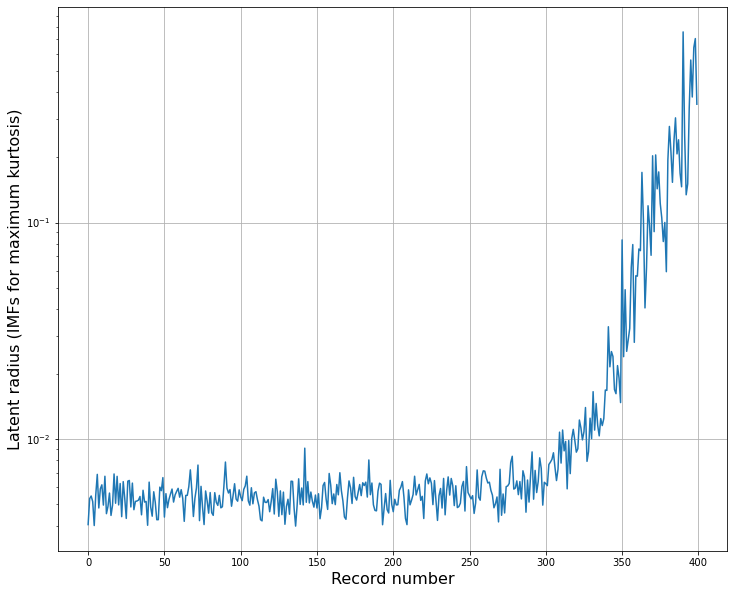

In [18]:
plt.figure(figsize = (12, 10))
plt.semilogy(np.mean(Rmat, axis = 1))
plt.xlabel("Record number", fontsize = 16)
plt.ylabel("Latent radius (IMFs for maximum kurtosis)", fontsize = 16)
plt.grid()
plt.show()